# Wine quality classifier

Using a random forest classifer to model the wine quality dataset from the UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/wine+quality

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

redwine = pd.read_csv('data/wine_quality_red.csv', sep=';')
whitewine = pd.read_csv('data/wine_quality_white.csv', sep=';')

## Red Wine

Let's start with the red wine.

In [2]:
redwine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
redwine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


A correlation matrix suggests that the columns in general aren't correlated.

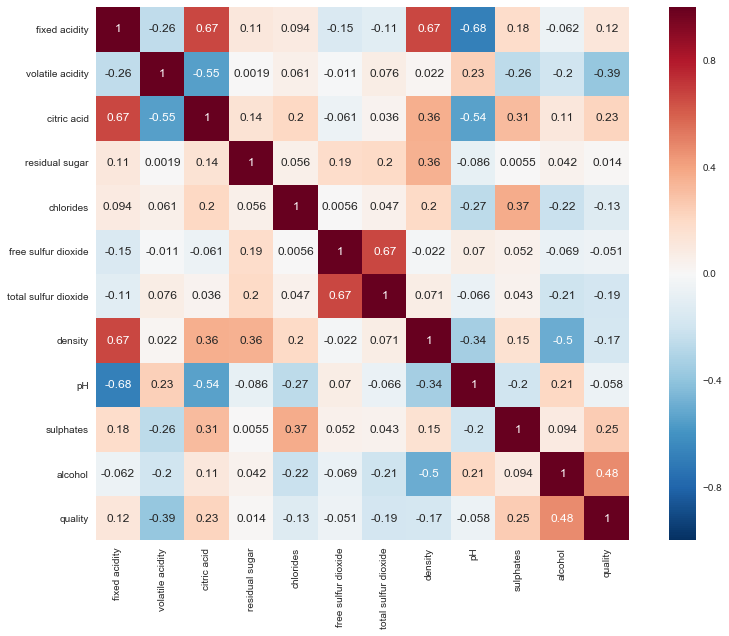

In [4]:
cmat = redwine.corr() # feature-wise correlation

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(cmat, square=True, annot=True) # heatmap

f.tight_layout()

## The model

Let's build our training and testing sets, and then the classifier.

In [5]:
train_rw, test_rw = train_test_split(redwine, test_size = 0.2) # 20% split

train_y_rw = train_rw[train_rw.columns[-1:]]
train_y_rw = np.reshape(train_y_rw.values,[1279,])
train_X_rw = train_rw[train_rw.columns[:-1]]

test_y_rw = test_rw[test_rw.columns[-1:]]
test_y_rw = np.reshape(test_y_rw.values,[320,])
test_X_rw = test_rw[test_rw.columns[:-1]]

seed = 10 # set seed

clf_rw = RandomForestClassifier(n_jobs=-1, oob_score = True, random_state = seed)

# to find the best hyperparameters
param_grid_rw = [{'n_estimators': [200,250,300],
                  'criterion': ['gini', 'entropy'],
                  'max_features': ['sqrt', 'log2']}
                ]

grid_search_rw = GridSearchCV(estimator=clf_rw, param_grid=param_grid_rw, cv=5, refit=True)

In [6]:
grid_search_rw.fit(train_X_rw, train_y_rw)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=True, random_state=10,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [200, 250, 300], 'criterion': ['gini', 'entropy'], 'max_features': ['sqrt', 'log2']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [7]:
grid_search_rw.best_params_

{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 250}

In [8]:
grid_search_rw.best_estimator_.score(test_X_rw, test_y_rw)

0.66562500000000002

## Outliers and a new category

The accuracy score above is low. Let's observe the distribution of each feature to discern possible outliers.

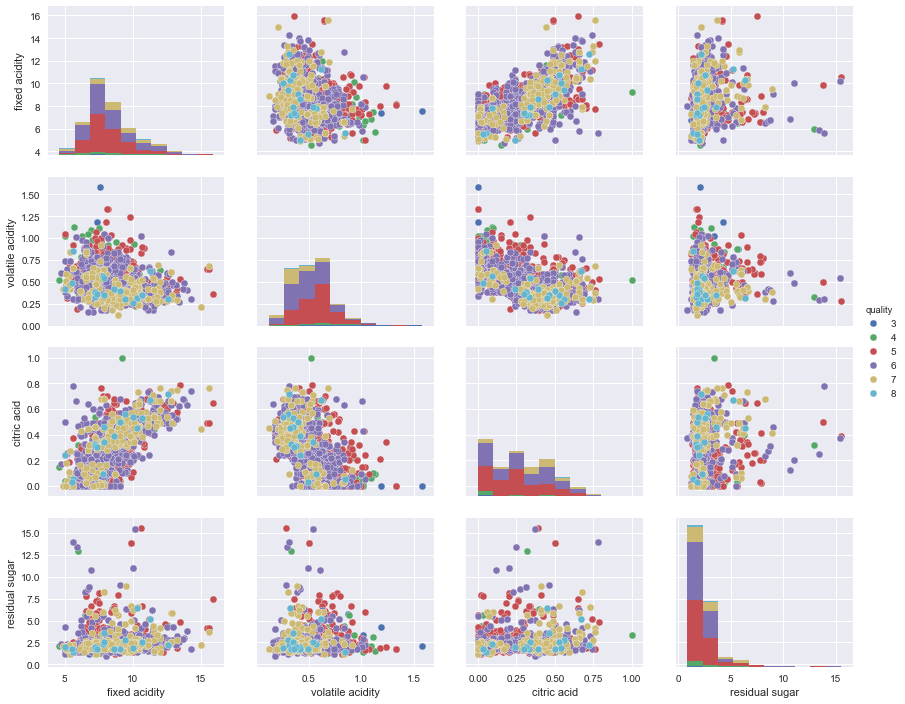

In [9]:
sns.pairplot(redwine, hue='quality', vars=['fixed acidity','volatile acidity', 'citric acid', 'residual sugar'], aspect=1.2)

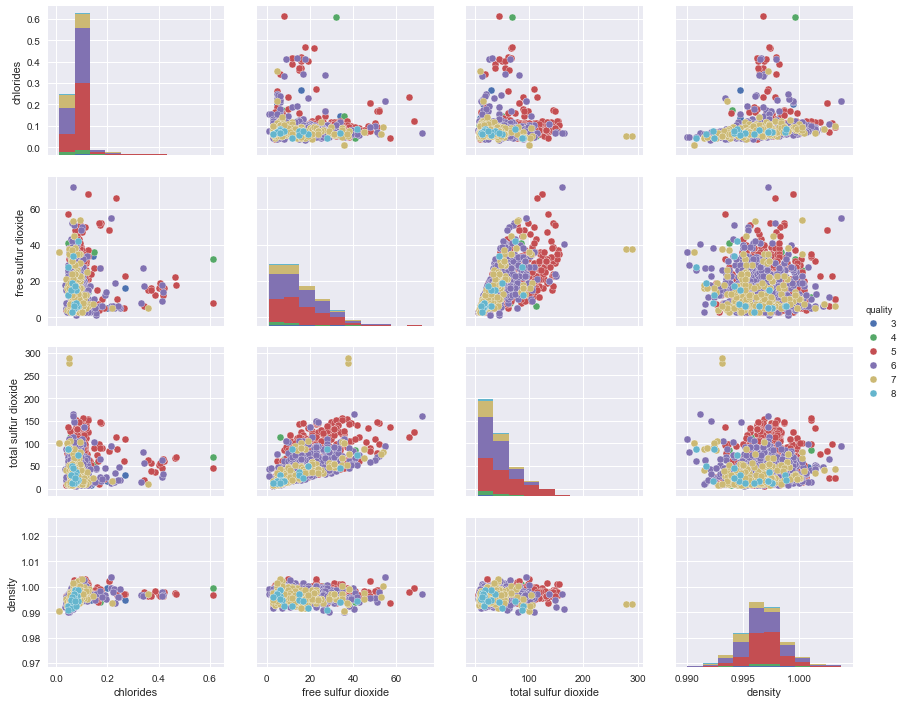

In [10]:
sns.pairplot(redwine, hue='quality', vars=['chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density'], aspect=1.2)

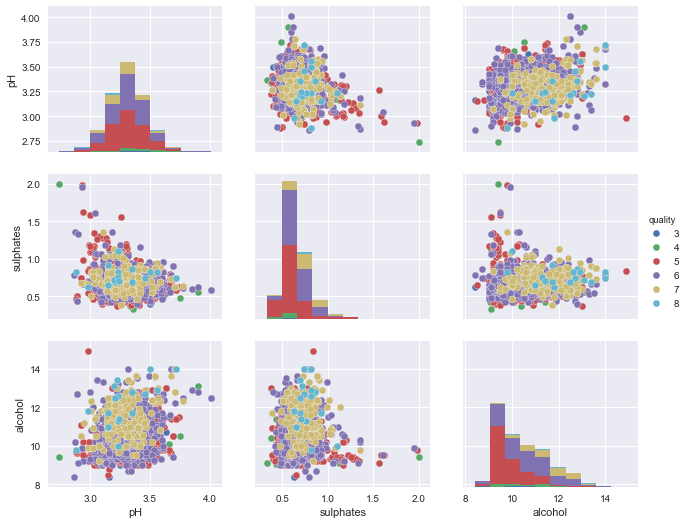

In [11]:
sns.pairplot(redwine, hue='quality', vars=['pH', 'sulphates', 'alcohol'], aspect=1.2)

Let's do away with the heavier outliers.

In [12]:
redwine_ = redwine.loc[(redwine['fixed acidity'] > 6) & (redwine['fixed acidity'] < 13)
                       & (redwine['volatile acidity'] < 1.1)
                       & (redwine['citric acid'] < 0.7)
                       & (redwine['residual sugar'] < 5.5)
                       & (redwine['chlorides'] < 0.15) 
                       & (redwine['free sulfur dioxide'] < 38) 
                       & (redwine['total sulfur dioxide'] < 150) 
                       & (redwine['density'] > 0.992) & (redwine['density'] < 1.002)
                       & (redwine['pH'] > 3) & (redwine['pH'] < 3.7) 
                       & (redwine['sulphates'] < 1) 
                       & (redwine['alcohol'] > 8.5) & (redwine['alcohol'] < 13)
                      ]

Next, let's separate the qualities into three further categories: 'bad', 'okay', and 'good'. But instead of attributing strings to categories, I will instead attribute numbers: 0 (bad), 1 (okay), 2 (good). 

Let's first look at the number of wines per quality score.

In [13]:
redwine_.groupby(['quality']).count()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
quality,,,,,,,,,,,
3,5,5,5,5,5,5,5,5,5,5,5
4,42,42,42,42,42,42,42,42,42,42,42
5,544,544,544,544,544,544,544,544,544,544,544
6,517,517,517,517,517,517,517,517,517,517,517
7,140,140,140,140,140,140,140,140,140,140,140
8,9,9,9,9,9,9,9,9,9,9,9


In [14]:
categorizer = lambda x: 0 if x == 3 else 0 if x == 4 else 1 if x == 5 else 1 if x == 6 else 2 # make categories
redwine_categorized = redwine_.assign(category = list(redwine_.quality.apply(categorizer)))
redwine_categorized = redwine_categorized.drop('quality', axis=1) # drop quality column

## Testing the model on preprocessed data

Let's now test our model with category as the new label. 

I will split the processed data as before.

In [15]:
train_rw_2, test_rw_2 = train_test_split(redwine_categorized, test_size = 0.2)

train_y_rw_2 = train_rw_2[train_rw_2.columns[-1:]]
train_y_rw_2 = np.reshape(train_y_rw_2.values,[1005,])
train_X_rw_2 = train_rw_2[train_rw_2.columns[:-1]]

test_y_rw_2 = test_rw_2[test_rw_2.columns[-1:]]
test_y_rw_2 = np.reshape(test_y_rw_2.values,[252,])
test_X_rw_2 = test_rw_2[test_rw_2.columns[:-1]]

clf_rw_2 = RandomForestClassifier(n_jobs=-1, oob_score = True, random_state = seed)

param_grid_rw_2 = [{'n_estimators': [200,250,300],
                  'criterion': ['gini', 'entropy'],
                  'max_features': ['sqrt', 'log2']}
                  ]

grid_search_rw_2 = GridSearchCV(estimator=clf_rw_2, param_grid=param_grid_rw_2, cv=5, refit=True)

In [16]:
grid_search_rw_2.fit(train_X_rw_2, train_y_rw_2)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=True, random_state=10,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [200, 250, 300], 'criterion': ['gini', 'entropy'], 'max_features': ['sqrt', 'log2']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [17]:
grid_search_rw_2.best_estimator_.score(test_X_rw_2, test_y_rw_2)

0.91269841269841268

That's a big improvement! Let's repeat the process for white wine.

# White Wine

This section follows a similar approach (except the removal of outliers - as that did not affect the accuracy in a meaningful way for white wine).

In [18]:
whitewine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
fixed acidity           4898 non-null float64
volatile acidity        4898 non-null float64
citric acid             4898 non-null float64
residual sugar          4898 non-null float64
chlorides               4898 non-null float64
free sulfur dioxide     4898 non-null float64
total sulfur dioxide    4898 non-null float64
density                 4898 non-null float64
pH                      4898 non-null float64
sulphates               4898 non-null float64
alcohol                 4898 non-null float64
quality                 4898 non-null int64
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


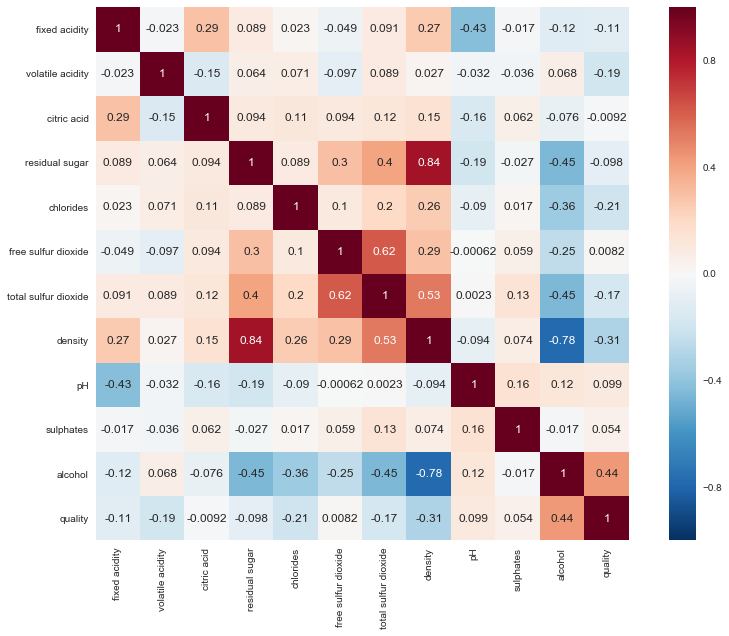

In [19]:
cmat = whitewine.corr() # feature-wise correlation

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(cmat, square=True, annot=True) # heatmap

f.tight_layout()

In [20]:
train_ww, test_ww = train_test_split(whitewine, test_size = 0.4)

train_y_ww = train_ww[train_ww.columns[-1:]]
train_y_ww = np.reshape(train_y_ww.values,[2938,])
train_X_ww = train_ww[train_ww.columns[:-1]]

test_y_ww = test_ww[test_ww.columns[-1:]]
test_y_ww = np.reshape(test_y_ww.values,[1960,])
test_X_ww = test_ww[test_ww.columns[:-1]]

clf_ww = RandomForestClassifier(n_jobs=-1, oob_score = True, random_state = seed)

param_grid_ww = [{'n_estimators': [300,400,500],
                  'criterion': ['gini', 'entropy'],
                  'max_features': ['sqrt', 'log2']}
                ]

grid_search_ww = GridSearchCV(estimator=clf_ww, param_grid=param_grid_ww, cv=3, refit=True)
grid_search_ww.fit(train_X_ww, train_y_ww)
grid_search_ww.best_estimator_.score(test_X_ww, test_y_ww)

0.64030612244897955

In [21]:
whitewine.groupby(['quality']).count()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
quality,,,,,,,,,,,
3,20,20,20,20,20,20,20,20,20,20,20
4,163,163,163,163,163,163,163,163,163,163,163
5,1457,1457,1457,1457,1457,1457,1457,1457,1457,1457,1457
6,2198,2198,2198,2198,2198,2198,2198,2198,2198,2198,2198
7,880,880,880,880,880,880,880,880,880,880,880
8,175,175,175,175,175,175,175,175,175,175,175
9,5,5,5,5,5,5,5,5,5,5,5


In [22]:
categorizer = lambda x: 0 if x == 3 else 0 if x == 4 else 1 if x == 5 else 1 if x == 6 else 1 if x == 7 else 2 # make categories
whitewine_categorized = whitewine.assign(category = list(whitewine.quality.apply(categorizer)))
whitewine_categorized = whitewine_categorized.drop('quality', axis=1) # drop quality column

train_ww_2, test_ww_2 = train_test_split(whitewine_categorized, test_size = 0.3)

train_y_ww_2 = train_ww_2[train_ww_2.columns[-1:]]
train_y_ww_2 = np.reshape(train_y_ww_2.values,[3428,])
train_X_ww_2 = train_ww_2[train_ww_2.columns[:-1]]

test_y_ww_2 = test_ww_2[test_ww_2.columns[-1:]]
test_y_ww_2 = np.reshape(test_y_ww_2.values,[1470,])
test_X_ww_2 = test_ww_2[test_ww_2.columns[:-1]]

clf_ww_2 = RandomForestClassifier(n_jobs=-1, oob_score = True, random_state = seed)

param_grid_ww_2 = [{'n_estimators': [300,400,500],
                  'criterion': ['gini', 'entropy'],
                  'max_features': ['sqrt', 'log2']}
                ]

grid_search_ww_2 = GridSearchCV(estimator=clf_ww_2, param_grid=param_grid_ww_2, cv=3, refit=True)
grid_search_ww_2.fit(train_X_ww_2, train_y_ww_2)
grid_search_ww_2.best_estimator_.score(test_X_ww_2, test_y_ww_2)

0.93809523809523809

# Conclusion

Basic preprocessing and outlier removal improved our classifier's accuracy quite a bit, but there are a few things I'd like to consider moving forward:

1) This data set is imbalanced: (number of average wines is much more than excellent and poor wines). Perhaps I'll employ undersampling techniques. <br>
2) There are better ways to deal with outliers, so I might look into those. <br>
3) Lastly, try other models, like xgboost.

I'll revisit this in the future, keeping the above in mind. 